In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from segmentation import AudioSegmenting
from embedding import Embedding
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

a = AudioSegmenting(device)
a.transcribe('eleven/11.mp3')
segments = a.segments

e = Embedding(device, 'eleven/11.wav')
embeddings, _ = e.create_embeddings(segments)

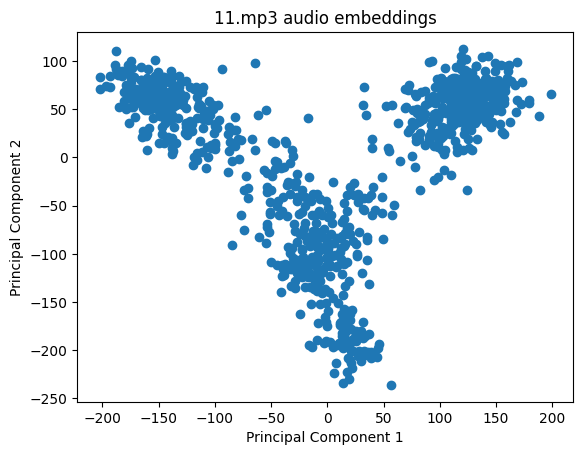

In [31]:
plt.clf()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title("11.mp3 audio embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

<Figure size 640x480 with 0 Axes>

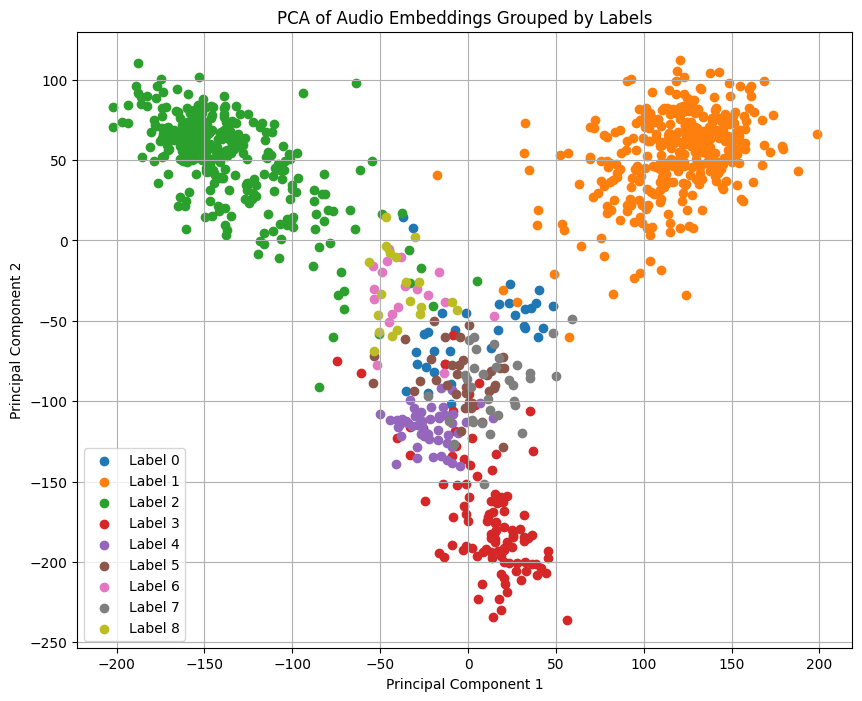

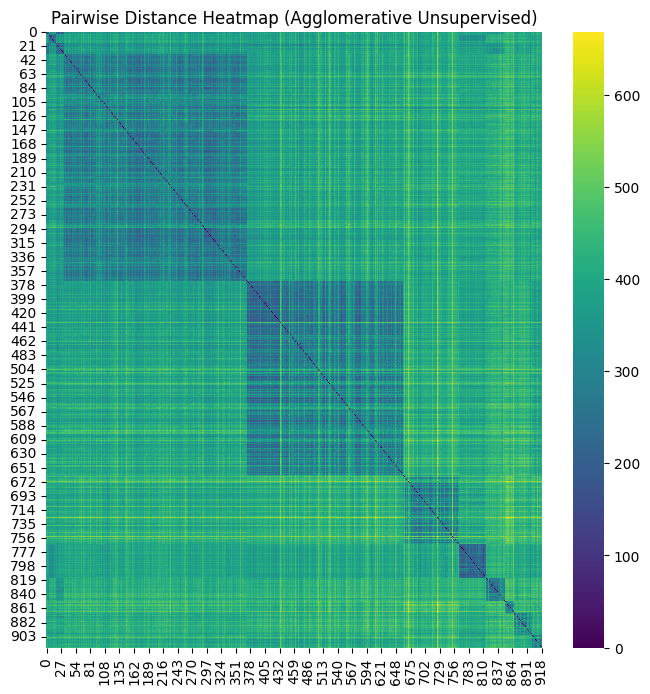

In [57]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

agglo = AgglomerativeClustering(n_clusters=None, distance_threshold=1150).fit(embeddings)
labels = agglo.labels_

unique_labels = np.unique(labels)
plt.clf()
plt.figure(figsize=(10, 8))
for label in unique_labels:
    # Select embeddings corresponding to the current label
    label_mask = labels == label
    plt.scatter(
        reduced_embeddings[label_mask, 0],
        reduced_embeddings[label_mask, 1],
        label=f'Label {label}'
    )

# Add plot details
plt.title("PCA of Audio Embeddings Grouped by Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

plt.close()

from scipy.spatial.distance import pdist, squareform
import seaborn as sns

# Compute pairwise distances
pairwise_distances = squareform(pdist(embeddings))

plt.figure(figsize=(8, 8))

# Heatmap for K-Means clustering
sns.heatmap(pairwise_distances[np.argsort(labels)][:, np.argsort(labels)], cmap="viridis")
plt.title("Pairwise Distance Heatmap (Agglomerative Unsupervised)")
plt.show()

# COPKmeans demonstrations

In [45]:
unlabeled_embeddings = embeddings

from segmentation import FileSegmenting

fs = FileSegmenting('eleven/transcript.rttm')
fs.transcribe()
labeled_segments = fs.get_segments(0.6)

labeled_embeddings, labeled_labels = e.create_embeddings(labeled_segments)

In [63]:
from sklearn.metrics.pairwise import euclidean_distances

# With trial and error distance threshold, find initial centroids.
# agglo = AgglomerativeClustering(n_clusters=None, distance_threshold=1150).fit(unlabeled_embeddings)
agglo = AgglomerativeClustering(n_clusters=9, distance_threshold=None).fit(unlabeled_embeddings)
agglo_labels = agglo.labels_

r = True

def compute_centroids(data, labels):
    unique_labels = np.unique(labels)
    centroids = []
    for label in unique_labels:
        # Get all points belonging to the current cluster
        cluster_points = data[labels == label]
        # Compute the mean of the points in the cluster to approximate the centroid
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
    return np.array(centroids)

agglo_centroids = compute_centroids(unlabeled_embeddings, agglo_labels)

# Unlabeled are integers whereas the rttm have strings, so add conversion tables
speaker_name_to_label = {name: i for i, name in enumerate(np.unique(labeled_labels))}
label_to_speaker_name = {v: k for k, v in speaker_name_to_label.items()}

# Convert labeled labels to integers
labeled_labels_int = np.array([speaker_name_to_label[name] for name in labeled_labels])

class COPKMeans:
    def __init__(self, n_clusters, must_link=[], cannot_link=[], max_iter=300):
        self.n_clusters = n_clusters
        self.must_link = must_link
        self.cannot_link = cannot_link
        self.max_iter = max_iter

    def fit(self, X):
        # Step 1: Initialize centroids randomly
        if r:
            centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        # centroids = self._kmeans_plus_plus_initialization(X)
        else:
            centroids = agglo_centroids
        labels = np.full(X.shape[0], -1)
        
        for _ in range(self.max_iter):
            new_labels = np.full(X.shape[0], -1)
            # new_labels = np.zeros(X.shape[0])
            
            # Step 2: Assign points to the nearest cluster considering constraints
            for i, point in enumerate(X):
                distances = euclidean_distances([point], centroids).flatten()
                
                # Sort clusters by distance
                sorted_clusters = np.argsort(distances)
                for cluster_id in sorted_clusters:
                    if self._satisfies_constraints(i, cluster_id, new_labels):
                        new_labels[i] = cluster_id
                        break
            
            # Step 3: Check for convergence
            if np.array_equal(labels, new_labels):
                break
            labels = new_labels
            
            # Step 4: Update centroids
            for cluster_id in range(self.n_clusters):
                points_in_cluster = X[labels == cluster_id]
                if len(points_in_cluster) > 0:
                    centroids[cluster_id] = np.mean(points_in_cluster, axis=0)
        
        self.labels_ = labels
        self.cluster_centers_ = centroids
    
    def _satisfies_constraints(self, point_index, cluster_id, labels):
        for (i, j) in self.must_link:
            if point_index == i and labels[j] != cluster_id:
                return False
            if point_index == j and labels[i] != cluster_id:
                return False
        
        for (i, j) in self.cannot_link:
            if point_index == i and labels[j] == cluster_id:
                return False
            if point_index == j and labels[i] == cluster_id:
                return False
        
        return True
    
    def _kmeans_plus_plus_initialization(self, X):
        unique_labels = np.unique(labeled_labels)
        n_labeled_clusters = len(unique_labels)
        assert n_labeled_clusters <= self.n_clusters

        # X is the dataset, k is the number of clusters
        centroids = []

        # Step 1: Initialize centroids with labeled data
        for label in unique_labels:
            label_cluster = labeled_embeddings[labeled_labels == label]
            centroid = np.mean(label_cluster, axis=0)
            centroids.append(centroid)

        # Step 2: Use k-means++ for the remaining centroids
        remaining_centroids_needed = self.n_clusters - n_labeled_clusters
        if remaining_centroids_needed > 0:
            # Select remaining centroids using k-means++
            distances = np.min(euclidean_distances(X, centroids), axis=1) ** 2

            for _ in range(remaining_centroids_needed):
                probabilities = distances / distances.sum()
                next_centroid_idx = np.random.choice(X.shape[0], p=probabilities)
                centroids.append(X[next_centroid_idx])

                # Update distances with the new centroid
                new_distances = euclidean_distances(X, [X[next_centroid_idx]]) ** 2
                distances = np.minimum(distances, new_distances.flatten())
        return np.array(centroids)


def generate_constraints(labeled_labels):
    must_link = []
    cannot_link = []
    
    # Generate must-link constraints
    for i in range(len(labeled_labels)):
        for j in range(i + 1, len(labeled_labels)):
            if labeled_labels[i] == labeled_labels[j]:
                must_link.append((i, j))
            else:
                cannot_link.append((i, j))
    
    return must_link, cannot_link

# First, we merge labeled and unlabeled embeddings
combined_embeddings = np.vstack((labeled_embeddings, unlabeled_embeddings))
mlink, clink = generate_constraints(labeled_labels_int)

cop_kmeans = COPKMeans(n_clusters=len(agglo_centroids), must_link=mlink, cannot_link=clink)
cop_kmeans.fit(combined_embeddings)
cluster_labels1 = cop_kmeans.labels_[len(labeled_embeddings):]

r = False
cop_kmeans = COPKMeans(n_clusters=len(agglo_centroids), must_link=mlink, cannot_link=clink)
cop_kmeans.fit(combined_embeddings)
cluster_labels2 = cop_kmeans.labels_[len(labeled_embeddings):]

<Figure size 640x480 with 0 Axes>

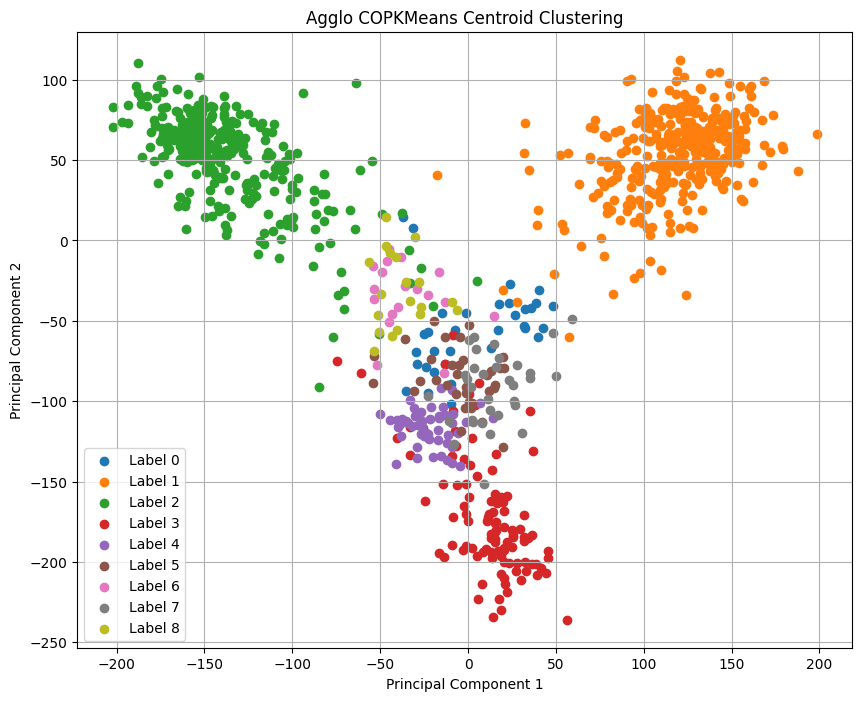

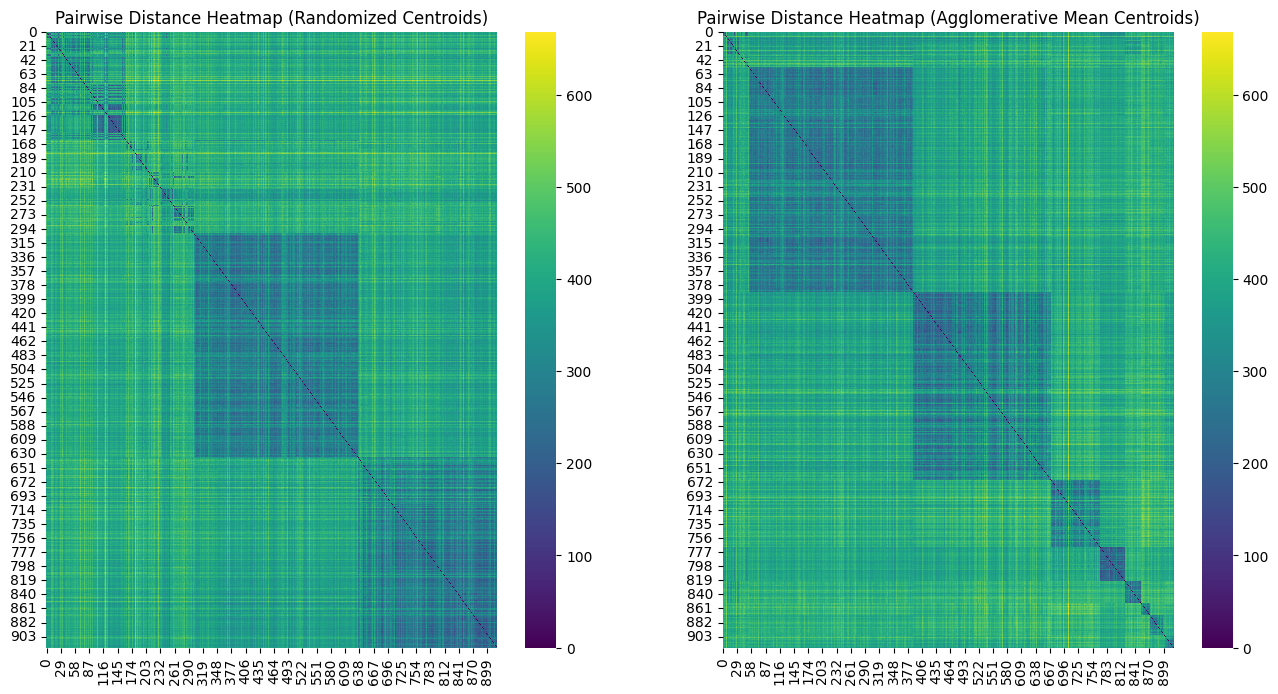

In [65]:
plt.clf()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(unlabeled_embeddings)
unique_labels = np.unique(cluster_labels1)

plt.figure(figsize=(10, 8))
for label in unique_labels:
    # Select embeddings corresponding to the current label
    label_mask = labels == label
    plt.scatter(
        reduced_embeddings[label_mask, 0],
        reduced_embeddings[label_mask, 1],
        label=f'Label {label}'
    )

# Add plot details
plt.title("Agglo COPKMeans Centroid Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


plt.close()

# Compute pairwise distances
pairwise_distances = squareform(pdist(unlabeled_embeddings))

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap for K-Means clustering
sns.heatmap(pairwise_distances[np.argsort(cluster_labels1)][:, np.argsort(cluster_labels1)], ax=axs[0], cmap="viridis")
axs[0].set_title("Pairwise Distance Heatmap (Randomized Centroids)")

# Heatmap for Agglomerative Clustering
sns.heatmap(pairwise_distances[np.argsort(cluster_labels2)][:, np.argsort(cluster_labels2)], ax=axs[1], cmap="viridis")
axs[1].set_title("Pairwise Distance Heatmap (Agglomerative Mean Centroids)")

plt.show()


# Using `agglo-constrained`

In [60]:
from scipy.sparse import csr_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Unlabeled are integers whereas the rttm have strings, so add conversion tables
speaker_name_to_label = {name: i for i, name in enumerate(np.unique(labeled_labels))}
label_to_speaker_name = {v: k for k, v in speaker_name_to_label.items()}

# Convert labeled labels to integers
labeled_labels_int = np.array([speaker_name_to_label[name] for name in labeled_labels])

combined_embeddings = np.vstack((labeled_embeddings, unlabeled_embeddings))

# Base Method
connectivity_knn = kneighbors_graph(combined_embeddings, n_neighbors=30, mode='connectivity', include_self=False)

# Using labeled data
n_labeled = len(labeled_embeddings)
n_unlabeled = len(unlabeled_embeddings)
labeled_connectivity = np.zeros((n_labeled, n_labeled))
for i in range(n_labeled):
    for j in range(i + 1, n_labeled):
        if labeled_labels_int[i] == labeled_labels_int[j]:
            labeled_connectivity[i, j] = 1
            labeled_connectivity[j, i] = 1
labeled_connectivity_sparse = csr_matrix(labeled_connectivity)
connectivity = csr_matrix((n_labeled + n_unlabeled, n_labeled + n_unlabeled))
connectivity[:n_labeled, :n_labeled] = labeled_connectivity_sparse
connectivity = connectivity + connectivity_knn

# With constraints
model = AgglomerativeClustering(
    linkage='average', connectivity=connectivity, n_clusters=9
).fit(combined_embeddings)
agglo_constrained_labels = model.labels_[len(labeled_embeddings):]

# Without constraints
# model = AgglomerativeClustering(
#     linkage='ward', n_clusters=9
# ).fit(combined_embeddings)
# agglo_constrained_labels = model.labels_[len(labeled_embeddings):]

# Without use of any labeled embeddings
# model = AgglomerativeClustering(
#     linkage='ward', n_clusters=9
# ).fit(unlabeled_embeddings)
# agglo_constrained_labels = model.labels_

# Number of speakers from cluster
from collections import Counter
print(f"Number of Distinct Clusters: {len(Counter(agglo_constrained_labels))}")

Number of Distinct Clusters: 9


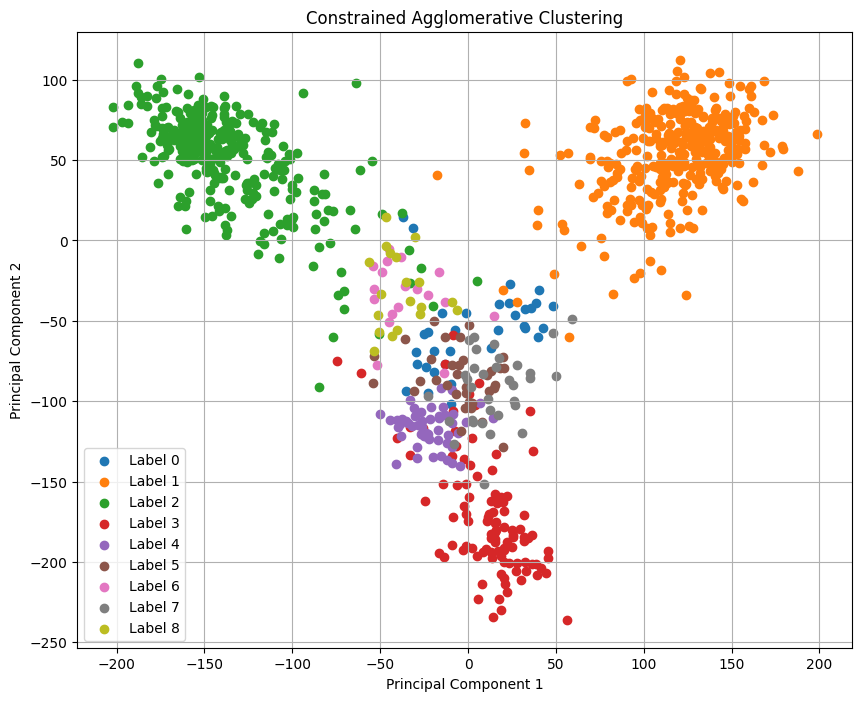

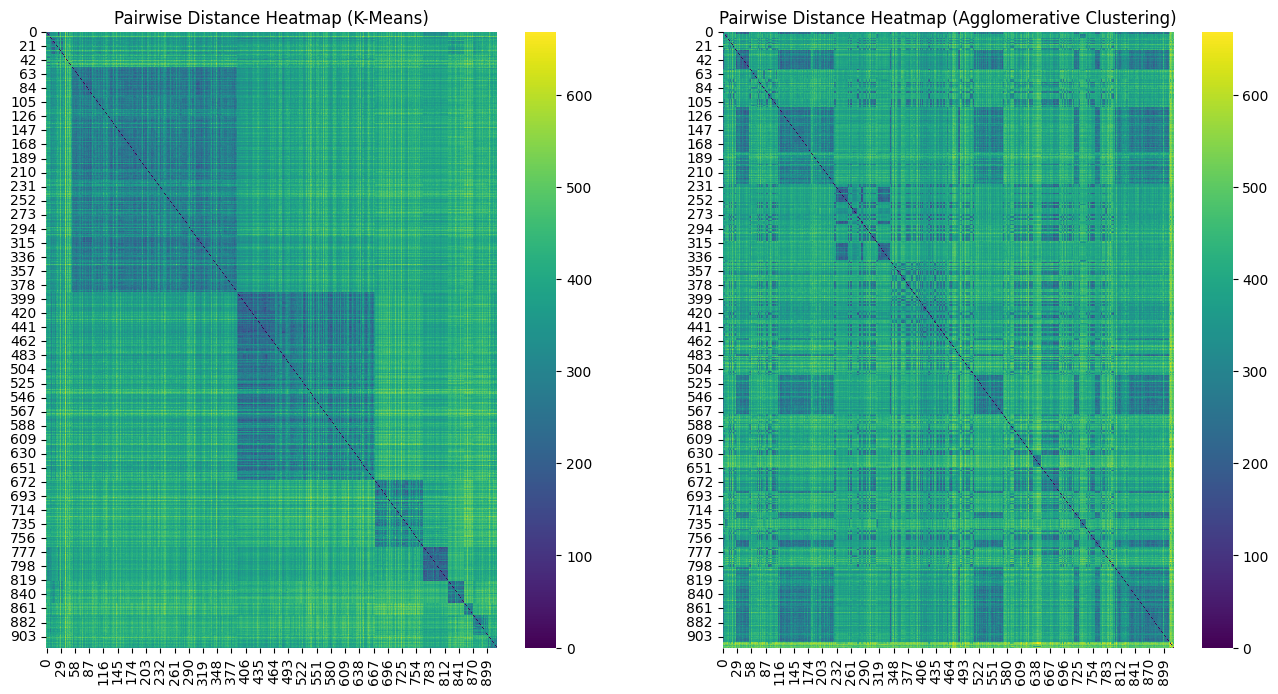

In [61]:
plt.clf()
plt.close()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(unlabeled_embeddings)
unique_labels = np.unique(cluster_labels)

plt.figure(figsize=(10, 8))
for label in unique_labels:
    # Select embeddings corresponding to the current label
    label_mask = labels == label
    plt.scatter(
        reduced_embeddings[label_mask, 0],
        reduced_embeddings[label_mask, 1],
        label=f'Label {label}'
    )

# Add plot details
plt.title("Constrained Agglomerative Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

plt.close()

from scipy.spatial.distance import pdist, squareform
import seaborn as sns

# Compute pairwise distances
pairwise_distances = squareform(pdist(unlabeled_embeddings))

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap for K-Means clustering
sns.heatmap(pairwise_distances[np.argsort(cluster_labels)][:, np.argsort(cluster_labels)], ax=axs[0], cmap="viridis")
axs[0].set_title("Pairwise Distance Heatmap (K-Means)")

# Heatmap for Agglomerative Clustering
sns.heatmap(pairwise_distances[np.argsort(agglo_constrained_labels)][:, np.argsort(agglo_constrained_labels)], ax=axs[1], cmap="viridis")
axs[1].set_title("Pairwise Distance Heatmap (Agglomerative Clustering)")

plt.show()
